In [1]:
%pip install -q matplotlib networkx pandas torchinfo
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy
import functions
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import poptorch
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import LamaHDataset
from datetime import datetime
from models import FloodMLP, FloodGCN, FloodGRAFFNN
from poptorch_geometric import FixedSizeDataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import AddSelfLoops, ToUndirected
from torch_geometric.utils import to_networkx
from torchinfo import summary
from tqdm import tqdm

In [3]:
functions.ensure_reproducibility(1)  # set to 2 and 3 for std runs

In [14]:
HPARAMS = {
    "data": {
        "window_size": 24,
        "stride_length": 6,
        "lead_time": 1,
        "bidirectional": True,
        "normalized": True
    },
    "model": {
        "architecture": "GRAFFNN",
        "propagation_dist": 5,
        "hidden_size": 128,
        "residual": True,
        "adjacency_type": "learned",
        "shared_weights": True,
        "step_size": 1
    },
    "training": {
        "num_epochs": 100,
        "batch_size": 32,
        "learning_rate": 0.005,
        "weight_decay": 0 # 5e-4
    }
}

In [ ]:
dataset = LamaHDataset("LamaH-CE",
                       years=range(2000, 2016),  # leaving 2016 and 2017 for testing
                       window_size_hrs=HPARAMS["data"]["window_size"],
                       stride_length_hrs=HPARAMS["data"]["stride_length"],
                       lead_time_hrs=HPARAMS["data"]["lead_time"],
                       bidirectional=HPARAMS["data"]["bidirectional"],
                       normalized=HPARAMS["data"]["normalized"])

Loading dataset into memory...


100%|██████████| 375/375 [00:31<00:00, 11.93it/s]


In [ ]:
train_dataset = dataset.subsample_years(y for y in range(2000, 2015) if y % 8 > 0)
val_dataset = dataset.subsample_years(y for y in range(2000, 2015) if y % 8 == 0)

In [ ]:
data = val_dataset[0]
print("# training samples:", len(train_dataset))
print("# validation samples:", len(val_dataset))
print("# vertices:", data.num_nodes)
print("# edges:", data.num_edges)
print("# vertex features:", data.num_node_features)
print("# edge features:", data.num_edge_features)
print("directed graph?:", data.is_directed())
print("isolated vertices?", data.has_isolated_nodes())
print("self-loops?", data.has_self_loops())
print("coalesced?", data.is_coalesced())
print("valid?", data.validate())
plt.figure(figsize=(12, 9))
graph = to_networkx(data, to_undirected=False)
# nx.draw_networkx(graph, pos=nx.drawing.kamada_kawai_layout(graph), with_labels=True, node_color=[tuple(torch.rand(3)) for _ in range(375)])

# training samples: 18936
# validation samples: 2920
# vertices: 375
# edges: 1123
# vertex features: 24
# edge features: 3
directed graph?: False
isolated vertices? False
self-loops? True
coalesced? True
valid? True


<Figure size 864x648 with 0 Axes>

In [15]:
edge_weights = functions.init_edge_weights(HPARAMS["model"]["adjacency_type"], data.edge_attr)
model = functions.construct_model(HPARAMS, edge_weights)
history = functions.train(model, train_dataset, val_dataset, HPARAMS, on_ipu=True)

Layer (type:depth-idx)                                  Param #
FloodGRAFFNN                                            1,123
├─Linear: 1-1                                           3,200
├─Linear: 1-2                                           129
├─ModuleList: 1-3                                       --
│    └─GRAFFConv: 2-1                                   49,152
│    └─GRAFFConv: 2-2                                   (recursive)
│    └─GRAFFConv: 2-3                                   (recursive)
│    └─GRAFFConv: 2-4                                   (recursive)
│    └─GRAFFConv: 2-5                                   (recursive)
Total params: 53,604
Trainable params: 53,604
Non-trainable params: 0


Graph compilation: 100%|██████████| 100/100 [01:58<00:00]


Training on IPU


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.00it/s]


[Epoch 1/100] Train: 2.0135 | Val 0.0298


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.76it/s]


[Epoch 2/100] Train: 0.0339 | Val 0.0206


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.07it/s]


[Epoch 3/100] Train: 0.0355 | Val 0.0306


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.40it/s]


[Epoch 4/100] Train: 0.0272 | Val 0.0208


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.08it/s]


[Epoch 5/100] Train: 0.0234 | Val 0.0189


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.83it/s]


[Epoch 6/100] Train: 0.0241 | Val 0.0143


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.25it/s]


[Epoch 7/100] Train: 0.0235 | Val 0.0183


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.63it/s]


[Epoch 8/100] Train: 0.0282 | Val 0.0143


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.41it/s]


[Epoch 9/100] Train: 0.0260 | Val 0.0136


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.55it/s]


[Epoch 10/100] Train: 0.0427 | Val 0.0174


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.51it/s]


[Epoch 11/100] Train: 0.0258 | Val 0.0135


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.47it/s]


[Epoch 12/100] Train: 0.0320 | Val 0.0141


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.94it/s]


[Epoch 13/100] Train: 0.0210 | Val 0.0306


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.37it/s]


[Epoch 14/100] Train: 0.0221 | Val 0.0126


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.83it/s]


[Epoch 15/100] Train: 0.0252 | Val 0.0135


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.09it/s]


[Epoch 16/100] Train: 0.0280 | Val 0.0130


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.37it/s]


[Epoch 17/100] Train: 0.0234 | Val 0.0127


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.96it/s]


[Epoch 18/100] Train: 0.0241 | Val 0.0119


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.92it/s]


[Epoch 19/100] Train: 0.0220 | Val 0.0484


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.35it/s]


[Epoch 20/100] Train: 0.0195 | Val 0.0120


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.13it/s]


[Epoch 21/100] Train: 0.0179 | Val 0.0116


Validating: 100%|██████████| 91/91 [00:00<00:00, 135.84it/s]


[Epoch 22/100] Train: 21.3758 | Val 0.3572


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.42it/s]


[Epoch 23/100] Train: 0.2465 | Val 4.2010


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.69it/s]


[Epoch 24/100] Train: 0.5986 | Val 0.1159


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.43it/s]


[Epoch 25/100] Train: 0.1369 | Val 4.5419


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.86it/s]


[Epoch 26/100] Train: 0.9938 | Val 0.0540


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.01it/s]


[Epoch 27/100] Train: 0.0821 | Val 0.0493


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.01it/s]


[Epoch 28/100] Train: 0.0555 | Val 11.0017


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.24it/s]


[Epoch 29/100] Train: 1.2865 | Val 0.1532


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.28it/s]


[Epoch 30/100] Train: 0.0582 | Val 0.0369


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.15it/s]


[Epoch 31/100] Train: 0.0465 | Val 0.0773


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.94it/s]


[Epoch 32/100] Train: 0.1685 | Val 2.2931


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.21it/s]


[Epoch 33/100] Train: 0.0330 | Val 0.0196


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.00it/s]


[Epoch 34/100] Train: 0.0261 | Val 0.0917


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.20it/s]


[Epoch 35/100] Train: 0.0531 | Val 0.0166


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.42it/s]


[Epoch 36/100] Train: 0.0267 | Val 0.0179


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.53it/s]


[Epoch 37/100] Train: 0.0816 | Val 0.0158


Validating: 100%|██████████| 91/91 [00:00<00:00, 135.90it/s]


[Epoch 38/100] Train: 0.2432 | Val 0.0164


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.40it/s]


[Epoch 39/100] Train: 0.0202 | Val 0.0169


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.32it/s]


[Epoch 40/100] Train: 0.0198 | Val 0.0141


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.14it/s]


[Epoch 41/100] Train: 0.0343 | Val 0.0158


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.51it/s]


[Epoch 42/100] Train: 0.0434 | Val 0.0159


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.62it/s]


[Epoch 43/100] Train: 0.0268 | Val 0.1616


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.79it/s]


[Epoch 44/100] Train: 0.0226 | Val 0.0139


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.62it/s]


[Epoch 45/100] Train: 0.0193 | Val 0.0131


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.38it/s]


[Epoch 46/100] Train: 0.0227 | Val 0.0675


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.51it/s]


[Epoch 47/100] Train: 0.0248 | Val 0.0133


Validating: 100%|██████████| 91/91 [00:00<00:00, 144.30it/s]


[Epoch 48/100] Train: 0.0207 | Val 0.0134


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.50it/s]


[Epoch 49/100] Train: 0.1925 | Val 0.0168


Validating: 100%|██████████| 91/91 [00:00<00:00, 134.55it/s]


[Epoch 50/100] Train: 0.0319 | Val 0.0197


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.39it/s]


[Epoch 51/100] Train: 0.0252 | Val 0.0202


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.46it/s]


[Epoch 52/100] Train: 0.0345 | Val 0.0138


Validating: 100%|██████████| 91/91 [00:00<00:00, 135.92it/s]


[Epoch 53/100] Train: 0.0387 | Val 0.0139


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.98it/s]


[Epoch 54/100] Train: 0.0199 | Val 0.0233


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.19it/s]


[Epoch 55/100] Train: 0.0197 | Val 0.0133


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.00it/s]


[Epoch 56/100] Train: 0.0244 | Val 0.0153


Validating: 100%|██████████| 91/91 [00:00<00:00, 144.49it/s]


[Epoch 57/100] Train: 0.0258 | Val 0.0139


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.25it/s]


[Epoch 58/100] Train: 0.0197 | Val 0.0137


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.65it/s]


[Epoch 59/100] Train: 0.0203 | Val 0.0136


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.98it/s]


[Epoch 60/100] Train: 6.3682 | Val 0.1968


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.48it/s]


[Epoch 61/100] Train: 0.1164 | Val 0.0385


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.97it/s]


[Epoch 62/100] Train: 0.0441 | Val 0.0278


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.68it/s]


[Epoch 63/100] Train: 0.0542 | Val 0.0232


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.19it/s]


[Epoch 64/100] Train: 0.0263 | Val 0.0185


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.51it/s]


[Epoch 65/100] Train: 0.0262 | Val 0.0182


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.67it/s]


[Epoch 66/100] Train: 0.0316 | Val 0.0196


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.12it/s]


[Epoch 67/100] Train: 0.0267 | Val 0.0467


Validating: 100%|██████████| 91/91 [00:00<00:00, 137.92it/s]


[Epoch 68/100] Train: 0.0277 | Val 0.0235


Validating: 100%|██████████| 91/91 [00:00<00:00, 135.98it/s]


[Epoch 69/100] Train: 0.1887 | Val 0.0144


Validating: 100%|██████████| 91/91 [00:00<00:00, 126.77it/s]


[Epoch 70/100] Train: 0.0204 | Val 0.0164


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.15it/s]


[Epoch 71/100] Train: 0.0218 | Val 0.0148


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.38it/s]


[Epoch 72/100] Train: 8.3463 | Val 0.4240


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.67it/s]


[Epoch 73/100] Train: 0.3732 | Val 0.0808


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.49it/s]


[Epoch 74/100] Train: 0.0331 | Val 0.0519


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.95it/s]


[Epoch 75/100] Train: 0.0252 | Val 0.0418


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.13it/s]


[Epoch 76/100] Train: 0.0242 | Val 0.0295


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.18it/s]


[Epoch 77/100] Train: 0.0246 | Val 0.0580


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.16it/s]


[Epoch 78/100] Train: 0.0230 | Val 0.0201


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.18it/s]


[Epoch 79/100] Train: 0.0599 | Val 0.0168


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.68it/s]


[Epoch 80/100] Train: 0.0446 | Val 1.4294


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.74it/s]


[Epoch 81/100] Train: 0.0263 | Val 0.0149


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.57it/s]


[Epoch 82/100] Train: 0.0213 | Val 0.0143


Validating: 100%|██████████| 91/91 [00:00<00:00, 135.38it/s]


[Epoch 83/100] Train: 0.0217 | Val 0.0148


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.19it/s]


[Epoch 84/100] Train: 0.0262 | Val 0.0141


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.17it/s]


[Epoch 85/100] Train: 0.0532 | Val 0.0140


Validating: 100%|██████████| 91/91 [00:00<00:00, 144.50it/s]


[Epoch 86/100] Train: 0.0257 | Val 0.0164


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.48it/s]


[Epoch 87/100] Train: 0.0221 | Val 0.0139


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.43it/s]


[Epoch 88/100] Train: 5791.6146 | Val 1336.7640


Validating: 100%|██████████| 91/91 [00:00<00:00, 143.41it/s]


[Epoch 89/100] Train: 234480128.1781 | Val 1873185.6790


Validating: 100%|██████████| 91/91 [00:00<00:00, 136.06it/s]


[Epoch 90/100] Train: 1108563.9825 | Val 786310.6181


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.84it/s]


[Epoch 91/100] Train: 1876351.5506 | Val 476105.0548


Validating: 100%|██████████| 91/91 [00:00<00:00, 138.52it/s]


[Epoch 92/100] Train: 302494.5635 | Val 1726138.8112


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.31it/s]


[Epoch 93/100] Train: 166295.0228 | Val 802045.8866


Validating: 100%|██████████| 91/91 [00:00<00:00, 144.44it/s]


[Epoch 94/100] Train: 106046.0871 | Val 112984.7646


Validating: 100%|██████████| 91/91 [00:00<00:00, 142.26it/s]


[Epoch 95/100] Train: 99451.2953 | Val 64929293.0830


Validating: 100%|██████████| 91/91 [00:00<00:00, 144.65it/s]


[Epoch 96/100] Train: 11014915.6970 | Val 178836.1119


Validating: 100%|██████████| 91/91 [00:00<00:00, 140.66it/s]


[Epoch 97/100] Train: 289373.1478 | Val 58740.6497


Validating: 100%|██████████| 91/91 [00:00<00:00, 141.89it/s]


[Epoch 98/100] Train: 81067.4992 | Val 32205.8224


Validating: 100%|██████████| 91/91 [00:00<00:00, 134.57it/s]


[Epoch 99/100] Train: 24314.3745 | Val 4037748.1359


Validating: 100%|██████████| 91/91 [00:00<00:00, 139.24it/s]


[Epoch 100/100] Train: 76158.6426 | Val 32939.4620


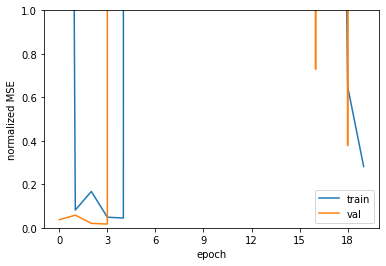

0.0487/0.0172


In [ ]:
functions.plot_loss(history["train_loss"], history["val_loss"])
best_epoch = torch.tensor(history['val_loss']).argmin()
print(f"{history['train_loss'][best_epoch]:.4f}/{history['val_loss'][best_epoch]:.4f}")

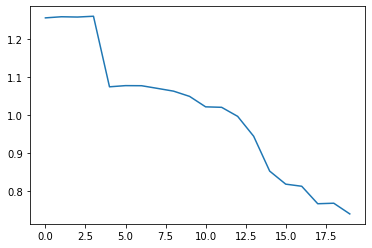

In [ ]:
plt.plot([param["edge_weights"].mean() for param in history["model_params"]])